<font size = '6' >**Loading packages**</font>

In [1]:
!pip install efficientnet -q

import os
import efficientnet.tfkeras as efn
import numpy as np
import pandas as pd
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

<font size = '6' >**Helper functions**</font>

In [2]:
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy


def build_decoder(with_labels=True, target_size=(256, 256), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)

        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, bsize=128, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset

<font size = '6' >**Prepare the green_data**</font>

In [3]:
df = pd.read_csv('../input/hpa-single-cell-image-classification/train.csv')

for i in range(19):
    df[f'{i}'] =0

for i in range(df.shape[0]):
    a = df.loc[i,'Label'].split('|')
    a_len = len(df.loc[i,'Label'].split('|'))
    for j in range(a_len ):
        df.loc[i,a[j]] = 1


df_green = df.copy()
df_green['ID'] = df_green['ID'] +'_green'
df_green.to_csv('df_green.csv',index = False)

# df_red = df.copy()
# df_red['ID'] = df_red['ID'] +'_red'
# df_red.to_csv('df_red.csv',index = False)

# df_blue = df.copy()
# df_blue['ID'] = df_blue['ID'] +'_blue'
# df_blue.to_csv('df_blue.csv',index = False)

# df_yellow = df.copy()
# df_yellow['ID'] = df_yellow['ID'] +'_yellow'
# df_yellow.to_csv('df_yellow.csv',index = False)

In [4]:
COMPETITION_NAME = "hpa-768768"
strategy = auto_select_accelerator()
BATCH_SIZE = strategy.num_replicas_in_sync * 16
GCS_DS_PATH = KaggleDatasets().get_gcs_path(COMPETITION_NAME)

Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas


In [5]:
df = df_green
label_cols = df.columns[2:21]
paths = GCS_DS_PATH + '/' + df['ID'] + '.png'
labels = df[label_cols].values

In [6]:
(train_paths, valid_paths, train_labels, valid_labels) = train_test_split(paths, labels, test_size=0.1, random_state=42)

In [7]:
IMSIZE = (224, 240, 260, 300, 380, 456, 528, 600)
IMS = 7

decoder = build_decoder(with_labels=True, target_size=(IMSIZE[IMS], IMSIZE[IMS]))
test_decoder = build_decoder(with_labels=False, target_size=(IMSIZE[IMS], IMSIZE[IMS]))

train_dataset = build_dataset(
    train_paths, train_labels, bsize=BATCH_SIZE, decode_fn=decoder
)

valid_dataset = build_dataset(
    valid_paths, valid_labels, bsize=BATCH_SIZE, decode_fn=decoder,
    repeat=False, shuffle=False, augment=False
)


In [8]:
try:
    n_labels = train_labels.shape[1]
except:
    n_labels = 1
    
with strategy.scope():
    model = tf.keras.Sequential([
        efn.EfficientNetB7(
            input_shape=(IMSIZE[IMS], IMSIZE[IMS], 3),
            weights='imagenet',
            include_top=False),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(n_labels, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr = 30e-5),
        loss='binary_crossentropy',
        metrics=["accuracy"])
        
    model.summary()

258441216/258434480 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 19, 19, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 19)                48659     
Total params: 64,146,339
Trainable params: 63,835,619
Non-trainable params: 310,720
_________________________________________________________________


In [9]:
colour = '_green'

In [10]:
steps_per_epoch = train_paths.shape[0] // BATCH_SIZE

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'efbn7_model{colour}.h5', save_best_only=True, monitor='val_loss', mode='min')
lr_Reducer = tf.keras.callbacks.ReduceLROnPlateau(
     monitor="val_loss", patience=2, min_lr=1e-6, mode='min',verbose = 1)

In [11]:
history = model.fit(
    train_dataset, 
    epochs=20,
    verbose=1,
    callbacks=[checkpoint, lr_Reducer],
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_dataset)

Epoch 1/20
153/153 [==============================] - 858s 4s/step - loss: 0.3070 - accuracy: 0.3817 - val_loss: 0.2031 - val_accuracy: 0.3961
Epoch 2/20
153/153 [==============================] - 225s 1s/step - loss: 0.1498 - accuracy: 0.5828 - val_loss: 0.1671 - val_accuracy: 0.4956
Epoch 3/20
153/153 [==============================] - 225s 1s/step - loss: 0.1296 - accuracy: 0.6138 - val_loss: 0.1507 - val_accuracy: 0.5273
Epoch 4/20
153/153 [==============================] - 225s 1s/step - loss: 0.1200 - accuracy: 0.6284 - val_loss: 0.1240 - val_accuracy: 0.5763
Epoch 5/20
153/153 [==============================] - 225s 1s/step - loss: 0.1108 - accuracy: 0.6322 - val_loss: 0.1183 - val_accuracy: 0.6057
Epoch 6/20
153/153 [==============================] - 224s 1s/step - loss: 0.1024 - accuracy: 0.6508 - val_loss: 0.1102 - val_accuracy: 0.6116
Epoch 7/20
153/153 [==============================] - 224s 1s/step - loss: 0.0954 - accuracy: 0.6586 - val_loss: 0.1100 - val_accuracy: 0.6240

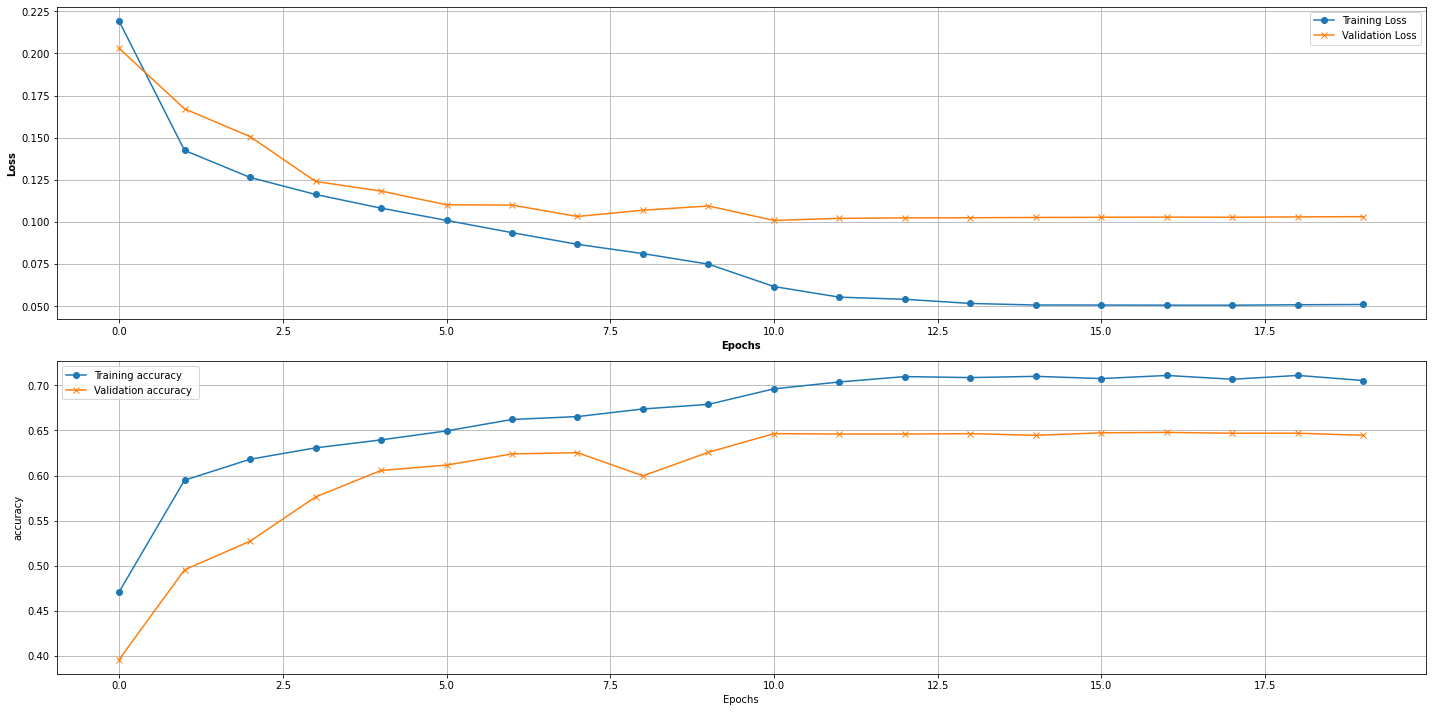

In [13]:
plt.figure(figsize = (20, 10))
 
plt.subplot(2,1,1)
plt.xlabel("Epochs", fontweight="bold")
plt.ylabel("Loss", fontweight="bold")
plt.plot(history.history["loss"], label = "Training Loss" , marker='o')
plt.plot(history.history["val_loss"], label = "Validation Loss" , marker='x')
plt.grid(True)
plt.legend()

plt.subplot(2,1,2)
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.plot(history.history["accuracy"], label = "Training accuracy" , marker='o')
plt.plot(history.history["val_accuracy"], label = "Validation accuracy " , marker='x')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv(f'history{colour}.csv')